In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("..")
import copy
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# setup sympy
from sympy import symbols, init_printing, simplify, collect, factor, flatten
import sympy as sp

init_printing(use_unicode=True)

# mLSTM Cell FLOP and Memory Operation counts

We perform all of this computation for the mLSTMsig and mLSTMexp.

## Define symbols

In [3]:
# dimensions
N_batch, N_head, N_chunk = symbols(
    "N_batch N_head N_chunk", integer=True, positive=True
)
T, L, d_qk, d_hv = symbols("T L d_qk d_hv", real=True, positive=True)
# flop factors
F_exp, F_log, F_sig, F_max, F_mask, F_abs = symbols(
    "F_exp F_log F_sig F_max F_mask F_abs", real=True, positive=True
)
# causal factor
F_causal = symbols("F_causal", real=True, positive=True)
# number of bytes
btytes_qkv, bytes_Cmn, bytes_if = symbols(
    "btytes_qkv bytes_Cmn bytes_if", real=True, positive=True
)

N_chunk = T / L

## Chunkwise Parallel Formulation

### FLOP counts

mLSTMexp:

In [4]:
# recurrent computation of the inter chunk states
flop_cwp_exp_gates = (
    2 * L + 0.5 * L * (L + 1) + L * (1 + F_exp + F_log + F_sig) + 3 + F_max + F_exp
)
flop_cwp_exp_numerator = 2 * d_qk * d_hv + 2 * L * d_qk * d_hv + L * d_qk
flop_cwp_exp_denominator = 2 * d_qk + 2 * L * d_qk
flop_cwp_exp_reccomp_inter = (
    flop_cwp_exp_gates + flop_cwp_exp_numerator + flop_cwp_exp_denominator
)

# parallel computation of the intra chunk outputs
flop_cwp_exp_cum_fgates = 0.5 * L * (L + 1) + L * (F_log + F_sig)
flop_cwp_exp_gate_matrix = F_causal * (L**2 * (3 + F_exp + F_max) + L * (1 + F_max))
flop_cwp_exp_intra_outputs = F_causal * (2 * L**2 * (d_qk + d_hv) + 3 * L**2)
flop_cwp_exp_parcomp_intra = (
    flop_cwp_exp_cum_fgates + flop_cwp_exp_gate_matrix + flop_cwp_exp_intra_outputs
)

# parallel computation of the inter chunk outputs
flop_cwp_exp_inter_outputs = 2 * L * d_qk * d_hv + 3 * L * d_qk

# combination of inter and intra chunk outputs
flop_cwp_exp_output_comb = 2 * L * d_hv + L * (1 + F_max + F_abs + F_exp)

flop_cwp_exp_expr_dict = {
    "flop_cwp_exp_gates": flop_cwp_exp_gates,
    "flop_cwp_exp_numerator": flop_cwp_exp_numerator,
    "flop_cwp_exp_denominator": flop_cwp_exp_denominator,
    "flop_cwp_exp_reccomp_inter": flop_cwp_exp_reccomp_inter,
    "flop_cwp_exp_cum_fgates": flop_cwp_exp_cum_fgates,
    "flop_cwp_exp_gate_matrix": flop_cwp_exp_gate_matrix,
    "flop_cwp_exp_intra_outputs": flop_cwp_exp_intra_outputs,
    "flop_cwp_exp_parcomp_intra": flop_cwp_exp_parcomp_intra,
    "flop_cwp_exp_inter_outputs": flop_cwp_exp_inter_outputs,
    "flop_cwp_exp_output_comb": flop_cwp_exp_output_comb,
}

In [5]:
# total flops mLSTMexp
flop_cwp_exp_recurrent = flop_cwp_exp_reccomp_inter
flop_cwp_exp_parallel = (
    flop_cwp_exp_parcomp_intra + flop_cwp_exp_inter_outputs + flop_cwp_exp_output_comb
)
flop_cwp_exp_total = (
    flop_cwp_exp_reccomp_inter
    + flop_cwp_exp_parcomp_intra
    + flop_cwp_exp_inter_outputs
    + flop_cwp_exp_output_comb
)

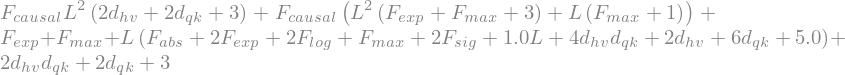

In [6]:
collect(flop_cwp_exp_total, L)

mLSTMsig:

In [7]:
# recurrent computation of the inter chunk states
flop_cwp_sig_gates = (
    2 * L + 0.5 * L * (L + 1) + L * F_exp + F_exp + 2 * L * (F_log + F_sig)
)
flop_cwp_sig_numerator = 2 * d_qk * d_hv + 2 * L * d_qk * d_hv + L * d_qk
flop_cwp_sig_reccomp_inter = flop_cwp_exp_gates + flop_cwp_sig_numerator

# parallel computation of the intra chunk outputs
flop_cwp_sig_cum_fgates = 0.5 * L * (L + 1) + 2 * L * (F_log + F_sig)
flop_cwp_sig_gate_matrix = F_causal * (L**2 * (2 + F_exp))
flop_cwp_sig_intra_outputs = F_causal * (2 * L**2 * (d_qk + d_hv) + 3 * L**2)
flop_cwp_sig_parcomp_intra = (
    flop_cwp_sig_cum_fgates + flop_cwp_sig_gate_matrix + flop_cwp_sig_intra_outputs
)

# parallel computation of the inter chunk outputs
flop_cwp_sig_inter_outputs = 2 * L * d_qk * d_hv + L * d_qk

# combination of inter and intra chunk outputs
flop_cwp_sig_output_comb = L * d_hv

flop_cwp_sig_expr_dict = {
    "flop_cwp_sig_gates": flop_cwp_sig_gates,
    "flop_cwp_sig_numerator": flop_cwp_sig_numerator,
    "flop_cwp_sig_reccomp_inter": flop_cwp_sig_reccomp_inter,
    "flop_cwp_sig_cum_fgates": flop_cwp_sig_cum_fgates,
    "flop_cwp_sig_gate_matrix": flop_cwp_sig_gate_matrix,
    "flop_cwp_sig_intra_outputs": flop_cwp_sig_intra_outputs,
    "flop_cwp_sig_parcomp_intra": flop_cwp_sig_parcomp_intra,
    "flop_cwp_sig_inter_outputs": flop_cwp_sig_inter_outputs,
    "flop_cwp_sig_output_comb": flop_cwp_sig_output_comb,
}

In [8]:
flop_cwp_sig_recurrent = flop_cwp_sig_reccomp_inter
flop_cwp_sig_parallel = (
    flop_cwp_sig_parcomp_intra + flop_cwp_sig_inter_outputs + flop_cwp_sig_output_comb
)
flop_cwp_sig_total = (
    flop_cwp_sig_reccomp_inter
    + flop_cwp_sig_parcomp_intra
    + flop_cwp_sig_inter_outputs
    + flop_cwp_sig_output_comb
)

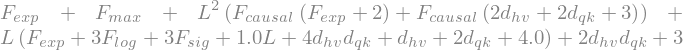

In [9]:
collect(flop_cwp_sig_total, L)

Compare mLSTMsig and mLSTMexp:

In [10]:
collect(
    flop_cwp_sig_total.subs(
        {F_exp: 1, F_log: 1, F_sig: 1, F_max: 1, F_mask: 1, F_abs: 1, F_causal: 0.5}
    ),
    L,
)

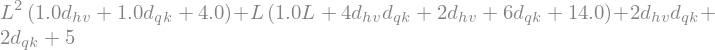

In [11]:
collect(
    flop_cwp_exp_total.subs(
        {F_exp: 1, F_log: 1, F_sig: 1, F_max: 1, F_mask: 1, F_abs: 1, F_causal: 0.5}
    ),
    L,
)

Substitute and simplify:

In [12]:
simplified_flop_cwp_exp_dict = copy.deepcopy(flop_cwp_exp_expr_dict)
for k, v in simplified_flop_cwp_exp_dict.items():
    simplified_flop_cwp_exp_dict[k] = collect(
        v.subs({F_exp: 1, F_log: 1, F_sig: 1, F_max: 1, F_mask: 1, F_abs: 1}), L
    )

In [13]:
simplified_flop_cwp_exp_dict

{'flop_cwp_exp_gates': L*(0.5*L + 6.5) + 5,
 'flop_cwp_exp_numerator': L*(2*d_hv*d_qk + d_qk) + 2*d_hv*d_qk,
 'flop_cwp_exp_denominator': 2*L*d_qk + 2*d_qk,
 'flop_cwp_exp_reccomp_inter': L*(0.5*L + 2*d_hv*d_qk + 3*d_qk + 6.5) + 2*d_hv*d_qk + 2*d_qk + 5,
 'flop_cwp_exp_cum_fgates': L*(0.5*L + 2.5),
 'flop_cwp_exp_gate_matrix': F_causal*(5*L**2 + 2*L),
 'flop_cwp_exp_intra_outputs': F_causal*L**2*(2*d_hv + 2*d_qk + 3),
 'flop_cwp_exp_parcomp_intra': F_causal*L**2*(2*d_hv + 2*d_qk + 3) + F_causal*(5*L**2 + 2*L) + L*(0.5*L + 2.5),
 'flop_cwp_exp_inter_outputs': L*(2*d_hv*d_qk + 3*d_qk),
 'flop_cwp_exp_output_comb': L*(2*d_hv + 4)}

In [14]:
simplified_flop_cwp_sig_dict = copy.deepcopy(flop_cwp_sig_expr_dict)
for k, v in simplified_flop_cwp_sig_dict.items():
    simplified_flop_cwp_sig_dict[k] = collect(
        v.subs({F_exp: 1, F_log: 1, F_sig: 1, F_max: 1, F_mask: 1, F_abs: 1}), L
    )

In [15]:
simplified_flop_cwp_sig_dict

{'flop_cwp_sig_gates': L*(0.5*L + 7.5) + 1,
 'flop_cwp_sig_numerator': L*(2*d_hv*d_qk + d_qk) + 2*d_hv*d_qk,
 'flop_cwp_sig_reccomp_inter': L*(0.5*L + 2*d_hv*d_qk + d_qk + 6.5) + 2*d_hv*d_qk + 5,
 'flop_cwp_sig_cum_fgates': L*(0.5*L + 4.5),
 'flop_cwp_sig_gate_matrix': 3*F_causal*L**2,
 'flop_cwp_sig_intra_outputs': F_causal*L**2*(2*d_hv + 2*d_qk + 3),
 'flop_cwp_sig_parcomp_intra': L**2*(F_causal*(2*d_hv + 2*d_qk + 3) + 3*F_causal) + L*(0.5*L + 4.5),
 'flop_cwp_sig_inter_outputs': L*(2*d_hv*d_qk + d_qk),
 'flop_cwp_sig_output_comb': L*d_hv}

## Recurrent Formulation

### FLOP counts

mLSTMexp:

In [16]:
flop_rec_exp_gates = 4 + 2 * F_exp + F_log + F_sig + F_max
flop_rec_exp_cell_update = 4 * d_qk * d_hv
flop_rec_exp_denom = 6 * d_qk + d_hv + 1 + F_abs + F_max
flop_rec_exp_output = 2 * d_hv * d_qk + d_qk

flop_rec_exp_total = (
    flop_rec_exp_gates
    + flop_rec_exp_cell_update
    + flop_rec_exp_denom
    + flop_rec_exp_output
)

In [17]:
flop_rec_exp_total

mLSTMsig:

In [18]:
flop_rec_sig_gates = 2 * F_sig
flop_rec_sig_cell_update = 4 * d_qk * d_hv
flop_rec_sig_output = 2 * d_hv * d_qk + d_qk

flop_rec_sig_total = flop_rec_sig_gates + flop_rec_sig_cell_update + flop_rec_sig_output

In [19]:
flop_rec_sig_total

## Parallel Formulation

### FLOP counts

mLSTMexp:

In [20]:
flop_par_exp_cum_fgates = 0.5 * T * (T + 1) + T * (F_log + F_sig)
flop_par_exp_gate_matrix = T**2 * (3 + F_exp + F_max + F_mask)
flop_par_exp_attn_logits = F_causal * (2 * T**2 * d_qk + 2 * T**2)
flop_par_exp_normalization = F_causal * (T**2 * (3 + F_abs) + T * (F_exp + F_max))
flop_par_exp_outputs = F_causal * 2 * T**2 * d_hv

flop_par_exp_total = (
    flop_par_exp_cum_fgates
    + flop_par_exp_gate_matrix
    + flop_par_exp_attn_logits
    + flop_par_exp_normalization
    + flop_par_exp_outputs
)

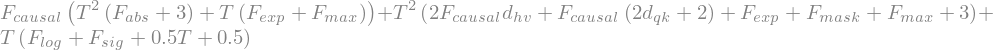

In [21]:
collect(flop_par_exp_total, T)

mLSTMsig:

In [22]:
flop_par_sig_cum_fgates = 0.5 * T * (T + 1) + 2 * T * (F_log + F_sig)
flop_par_sig_gate_matrix = T**2 * (3 + F_exp + F_max + F_mask)
flop_par_sig_attn_logits = F_causal * (2 * T**2 * d_qk + 2 * T**2)

flop_par_sig_outputs = F_causal * 2 * T**2 * d_hv

flop_par_sig_total = (
    flop_par_sig_cum_fgates
    + flop_par_sig_gate_matrix
    + flop_par_sig_attn_logits
    + flop_par_sig_outputs
)

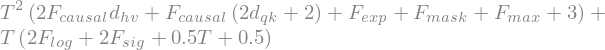

In [23]:
collect(flop_par_sig_total, T)

Compare mLSTMsig and mLSTMexp:

In [24]:
collect(
    flop_par_exp_total.subs(
        {F_exp: 1, F_log: 1, F_sig: 1, F_max: 1, F_mask: 1, F_abs: 1, F_causal: 0.5}
    ),
    T,
)

In [25]:
collect(
    flop_par_sig_total.subs(
        {F_exp: 1, F_log: 1, F_sig: 1, F_max: 1, F_mask: 1, F_abs: 1, F_causal: 0.5}
    ),
    T,
)

## Compare the Total FLOP counts

We compare the flop counts for a single head for one sequence of length $T$.

In [26]:
subs_dict = {F_exp: 1, F_log: 1, F_sig: 1, F_max: 1, F_mask: 1, F_abs: 1}

### mLSTMexp

In [27]:
comp_flop_rec_exp_total = T * flop_rec_exp_total
comp_flop_cwp_exp_total = N_chunk * flop_cwp_exp_total
comp_flop_par_exp_total = flop_par_exp_total

In [28]:
simpl_comp_flop_rec_exp_total = collect(comp_flop_rec_exp_total.subs(subs_dict), T)
simpl_comp_flop_rec_exp_total

In [29]:
sp.latex(simpl_comp_flop_rec_exp_total)

'T \\left(6 d_{hv} d_{qk} + d_{hv} + 7 d_{qk} + 12\\right)'

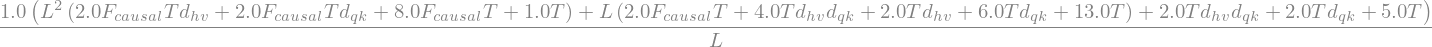

In [30]:
simpl_comp_flop_cwp_exp_total = collect(
    sp.cancel(collect(comp_flop_cwp_exp_total.subs(subs_dict), L)), L
)
simpl_comp_flop_cwp_exp_total

In [31]:
simpl_comp_flop_par_exp_total = collect(comp_flop_par_exp_total.subs(subs_dict), T)
simpl_comp_flop_par_exp_total

In [32]:
# define functions for plotting

fn_flop_rec_exp = sp.lambdify(
    (T, d_qk, d_hv), simpl_comp_flop_rec_exp_total, modules=["numpy"]
)
fn_flop_cwp_exp = sp.lambdify(
    (T, d_qk, d_hv, F_causal, L), simpl_comp_flop_cwp_exp_total, modules=["numpy"]
)
fn_flop_par_exp = sp.lambdify(
    (T, d_qk, d_hv, F_causal), simpl_comp_flop_par_exp_total, modules=["numpy"]
)

In [33]:
dqk = 64
dhv = 64
seq_len = 1024
chunk_size = 128
fcausal = 0.5

In [34]:
fn_flop_rec_exp(seq_len, dqk, dhv)

In [35]:
fn_flop_cwp_exp(seq_len, dqk, dhv, fcausal, chunk_size)

In [36]:
fn_flop_par_exp(seq_len, dqk, dhv, fcausal)

### mLSTMsig

In [37]:
comp_flop_rec_sig_total = T * flop_rec_sig_total
comp_flop_cwp_sig_total = N_chunk * flop_cwp_sig_total
comp_flop_par_sig_total = flop_par_sig_total

In [38]:
simpl_comp_flop_rec_sig_total = collect(comp_flop_rec_sig_total.subs(subs_dict), T)
simpl_comp_flop_rec_sig_total

In [39]:
sp.latex(simpl_comp_flop_rec_sig_total)

'T \\left(6 d_{hv} d_{qk} + d_{qk} + 2\\right)'

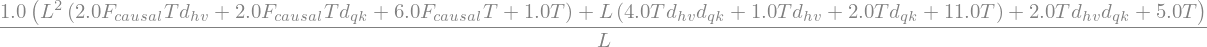

In [40]:
simpl_comp_flop_cwp_sig_total = collect(
    sp.cancel(collect(comp_flop_cwp_sig_total.subs(subs_dict), L)), L
)
simpl_comp_flop_cwp_sig_total

In [41]:
simpl_comp_flop_par_sig_total = collect(comp_flop_par_sig_total.subs(subs_dict), T)
simpl_comp_flop_par_sig_total

In [42]:
# define functions for plotting
fn_flop_rec_sig = sp.lambdify(
    (T, d_qk, d_hv), simpl_comp_flop_rec_sig_total, modules=["numpy"]
)
fn_flop_cwp_sig = sp.lambdify(
    (T, d_qk, d_hv, F_causal, L), simpl_comp_flop_cwp_sig_total, modules=["numpy"]
)
fn_flop_par_sig = sp.lambdify(
    (T, d_qk, d_hv, F_causal), simpl_comp_flop_par_sig_total, modules=["numpy"]
)

In [43]:
fn_flop_rec_sig(seq_len, dqk, dhv)

In [44]:
fn_flop_cwp_sig(seq_len, dqk, dhv, fcausal, chunk_size)

In [45]:
fn_flop_par_sig(seq_len, dqk, dhv, fcausal)

## Plot the Flop counts for varying chunk size

We now want to compare the FLOPs depending on the chunk size. 
We consider a single head and one batch, as we are only interested in the relative differences.

We choose sequence lengh $T=8192$, and head dimesions $d_{qk}=256$ and $d_{hv}=512$, which is the configuration we used for the xLSTM 7B model.

In [65]:
# plot params
num_points = 20

seq_len = np.repeat([8192], num_points)
dqk = 256
dhv = 512
fcausal = 0.5

In [66]:
flops_rec_exp = fn_flop_rec_exp(seq_len, dqk, dhv)
flops_rec_sig = fn_flop_rec_sig(seq_len, dqk, dhv)

In [89]:
chunk_sizes = np.logspace(0, 12, num=num_points, base=2)

In [90]:
flops_cwp_exp = fn_flop_cwp_exp(seq_len, dqk, dhv, fcausal, chunk_sizes)
flops_cwp_sig = fn_flop_cwp_sig(seq_len, dqk, dhv, fcausal, chunk_sizes)

In [91]:
flops_cwp_exp_nocausal = fn_flop_cwp_exp(seq_len, dqk, dhv, 0.75, chunk_sizes)

In [92]:
flops_par_exp = fn_flop_par_exp(seq_len, dqk, dhv, fcausal)
flops_par_sig = fn_flop_par_sig(seq_len, dqk, dhv, fcausal)

In [93]:
flops_par_exp

array([5.21771704e+10, 5.21771704e+10, 5.21771704e+10, 5.21771704e+10,
       5.21771704e+10, 5.21771704e+10, 5.21771704e+10, 5.21771704e+10,
       5.21771704e+10, 5.21771704e+10, 5.21771704e+10, 5.21771704e+10,
       5.21771704e+10, 5.21771704e+10, 5.21771704e+10, 5.21771704e+10,
       5.21771704e+10, 5.21771704e+10, 5.21771704e+10, 5.21771704e+10])

In [94]:
flops_par_exp / flops_rec_exp

array([8.07518181, 8.07518181, 8.07518181, 8.07518181, 8.07518181,
       8.07518181, 8.07518181, 8.07518181, 8.07518181, 8.07518181,
       8.07518181, 8.07518181, 8.07518181, 8.07518181, 8.07518181,
       8.07518181, 8.07518181, 8.07518181, 8.07518181, 8.07518181])

In [95]:
# normalize to the recurrent flops
flops_cwp_exp_norm = flops_cwp_exp / flops_rec_exp
flops_par_exp_norm = flops_par_exp / flops_rec_exp
flops_cwp_exp_norm_nocausal = flops_cwp_exp_nocausal / flops_rec_exp
flops_rec_exp_norm = flops_rec_exp / flops_rec_exp

flops_cwp_sig_norm = flops_cwp_sig / flops_rec_sig
flops_par_sig_norm = flops_par_sig / flops_rec_sig
flops_rec_sig_norm = flops_rec_sig / flops_rec_sig

In [96]:
flops_rec_sig, flops_cwp_sig

(array([6444564480, 6444564480, 6444564480, 6444564480, 6444564480,
        6444564480, 6444564480, 6444564480, 6444564480, 6444564480,
        6444564480, 6444564480, 6444564480, 6444564480, 6444564480,
        6444564480, 6444564480, 6444564480, 6444564480, 6444564480]),
 array([6.45729485e+09, 5.69940573e+09, 5.21335078e+09, 4.90448091e+09,
        4.71265010e+09, 4.60050328e+09, 4.54620221e+09, 4.53917287e+09,
        4.57804643e+09, 4.67039273e+09, 4.83419428e+09, 5.10134804e+09,
        5.52387666e+09, 6.18405880e+09, 7.21045125e+09, 8.80292262e+09,
        1.12715737e+10, 1.50971229e+10, 2.10245167e+10, 3.02079918e+10]))

In [97]:
from typing import Callable


def plot_flop_comparison_mlstm_formulation(
    fn_chunkwise_flops: Callable, figsize: tuple[float, float] = (7.0, 4.0)
):
    pass

In [98]:
from plot_config import get_plot_mpl_context

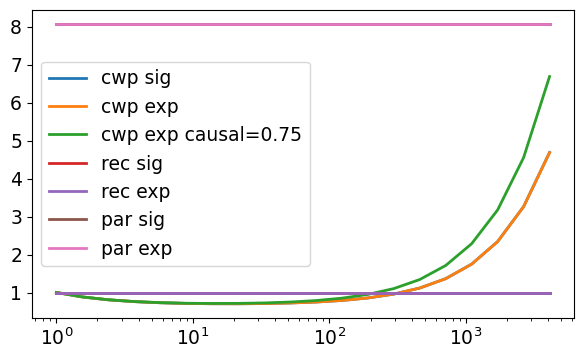

In [99]:
with get_plot_mpl_context():
    plt.figure(figsize=(7, 4))
    plt.plot(chunk_sizes, flops_cwp_sig_norm, label="cwp sig")
    plt.plot(chunk_sizes, flops_cwp_exp_norm, label="cwp exp")
    plt.plot(chunk_sizes, flops_cwp_exp_norm_nocausal, label="cwp exp causal=0.75")
    plt.plot(chunk_sizes, flops_rec_sig_norm, label="rec sig")
    plt.plot(chunk_sizes, flops_rec_exp_norm, label="rec exp")
    plt.plot(chunk_sizes, flops_par_sig_norm, label="par sig")
    plt.plot(chunk_sizes, flops_par_exp_norm, label="par exp")
    plt.legend()
    plt.xscale("log")
    # plt.yscale("log")
    # plt.xlim(1, 300)

In [58]:
flops_cwp_exp / flops_cwp_sig

array([1.01814095, 1.01843862, 1.0186392 , 1.01872922, 1.01869866,
       1.01853324, 1.01821014, 1.01769917, 1.01697134, 1.0160157 ,
       1.01486   , 1.01358213, 1.01229735, 1.01112167, 1.01013442,
       1.00936331, 1.00879433, 1.00839187, 1.00811563, 1.00792991])

In [59]:
flops_par_exp / flops_par_sig

array([1.01475919, 1.01475919, 1.01475919, 1.01475919, 1.01475919,
       1.01475919, 1.01475919, 1.01475919, 1.01475919, 1.01475919,
       1.01475919, 1.01475919, 1.01475919, 1.01475919, 1.01475919,
       1.01475919, 1.01475919, 1.01475919, 1.01475919, 1.01475919])

In [60]:
flops_rec_exp / flops_rec_sig

array([1.01858615, 1.01858615, 1.01858615, 1.01858615, 1.01858615,
       1.01858615, 1.01858615, 1.01858615, 1.01858615, 1.01858615,
       1.01858615, 1.01858615, 1.01858615, 1.01858615, 1.01858615,
       1.01858615, 1.01858615, 1.01858615, 1.01858615, 1.01858615])

In [61]:
# Note the mLSTMexp has only 0.2% more flops than mLSTMsig
# normalization is only a few flops

In [62]:
# 1.01475919